In [118]:
# Import the necessary libraries
import random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# seed for reproducibility
rd.seed(42)

### Multinomial Classification Models

In [119]:
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)
X = df.drop(columns=["Addiction Level"])
y = df["Addiction Level"]

def standardize_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X_scaled

standardized_X = standardize_data(X)

X_train, X_test, y_train, y_test = train_test_split(standardized_X, y, test_size=0.2, random_state=100, shuffle=True)

In [120]:
def fit_classification_model(m, y, X) -> float:
    # This function was implemented with type overriding of both a model and a model name
    if isinstance(m, str):
        if m == "KNN":
            m = KNeighborsClassifier(5)
        elif m == "LogisticRegression":
            m = LogisticRegression(max_iter=10000)
        elif m == "NaiveBayes":
            m = GaussianNB()

    return m.fit(X, y)

In [121]:
models = ["KNN", "LogisticRegression", "NaiveBayes"]
metrics = ["accuracy", "precision", "recall"]

results = pd.DataFrame(index=models, columns=metrics)

for m in models:
    model = fit_classification_model(m,y_train,X_train)
    y_pred = model.predict(X_test)

    results.loc[m, "accuracy"] = accuracy_score(y_test, y_pred)
    results.loc[m, "precision"] = precision_score(y_test, y_pred, average='weighted')
    results.loc[m, "recall"] = recall_score(y_test, y_pred, average='weighted')
    
print(results)

                   accuracy precision recall
KNN                   0.755  0.772783  0.755
LogisticRegression     0.84  0.833321   0.84
NaiveBayes            0.965  0.969174  0.965


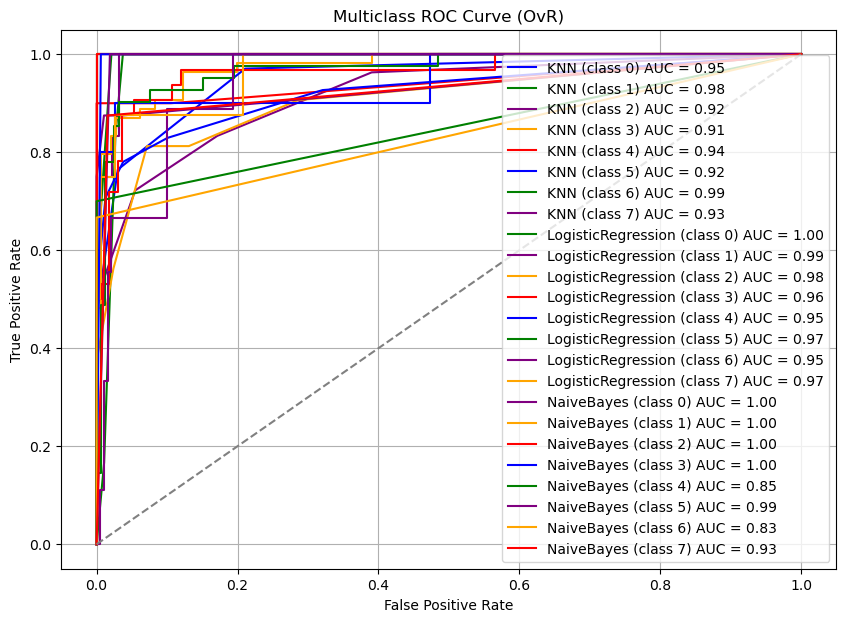

In [122]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

roc_data = {}

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

colors = ["blue", "green", "purple", "orange", "red"]

plt.figure(figsize=(10, 7))

for i, m in enumerate(models):
    model = fit_classification_model(m, y_train, X_train)
    y_prob = model.predict_proba(X_test)

    # Compute AUC using all class probabilities
    auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
    
    # Plot ROC curve for each class
    for j in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, j], y_prob[:, j])
        plt.plot(
            fpr,
            tpr,
            label=f"{m} (class {classes[j]}) AUC = {roc_auc_score(y_test_bin[:, j], y_prob[:, j]):.2f}",
            color=colors[(i + j) % len(colors)]
        )

plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (OvR)")
plt.legend()
plt.grid(True)
plt.show()


In [123]:
auc_per_class = {}

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

for m in models:
    model = fit_classification_model(m, y_train, X_train)
    y_prob = model.predict_proba(X_test)

    auc_per_class[m] = {}
    for j, class_label in enumerate(classes):
        auc = roc_auc_score(y_test_bin[:, j], y_prob[:, j])
        auc_per_class[m][class_label] = auc

for m in models:
    print(f"\nAUC for model: {m}")
    for class_label, auc in auc_per_class[m].items():
        print(f"  Class {class_label}: AUC = {auc:.2f}")



AUC for model: KNN
  Class 0: AUC = 0.95
  Class 1: AUC = 0.98
  Class 2: AUC = 0.92
  Class 3: AUC = 0.91
  Class 4: AUC = 0.94
  Class 5: AUC = 0.92
  Class 6: AUC = 0.99
  Class 7: AUC = 0.93

AUC for model: LogisticRegression
  Class 0: AUC = 1.00
  Class 1: AUC = 0.99
  Class 2: AUC = 0.98
  Class 3: AUC = 0.96
  Class 4: AUC = 0.95
  Class 5: AUC = 0.97
  Class 6: AUC = 0.95
  Class 7: AUC = 0.97

AUC for model: NaiveBayes
  Class 0: AUC = 1.00
  Class 1: AUC = 1.00
  Class 2: AUC = 1.00
  Class 3: AUC = 1.00
  Class 4: AUC = 0.85
  Class 5: AUC = 0.99
  Class 6: AUC = 0.83
  Class 7: AUC = 0.93


### Multinomial Classification Model - Correlated Features

In [124]:
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

df_full = df[['Time of Day_Morning', 'Time of Day_Night', 'Watch Hour', 'ProductivityLoss', 'Satisfaction', 'Self Control', 'Addiction Level']]
X = df_full.drop('Addiction Level', axis = 1)
y = df_full['Addiction Level']

def standardize_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X_scaled

standardized_X = standardize_data(X)

X_train, X_test, y_train, y_test = train_test_split(standardized_X, y, test_size=0.2, random_state=100, shuffle=True)

In [125]:
models = ["KNN", "LogisticRegression", "NaiveBayes"]
metrics = ["accuracy", "precision", "recall"]

results = pd.DataFrame(index=models, columns=metrics)

for m in models:
    model = fit_classification_model(m,y_train,X_train)
    y_pred = model.predict(X_test)

    results.loc[m, "accuracy"] = accuracy_score(y_test, y_pred)
    results.loc[m, "precision"] = precision_score(y_test, y_pred, average='weighted')
    results.loc[m, "recall"] = recall_score(y_test, y_pred, average='weighted')
    
print(results)

                   accuracy precision recall
KNN                     1.0       1.0    1.0
LogisticRegression     0.91  0.877066   0.91
NaiveBayes              1.0       1.0    1.0


/Users/victoriazbierowski/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


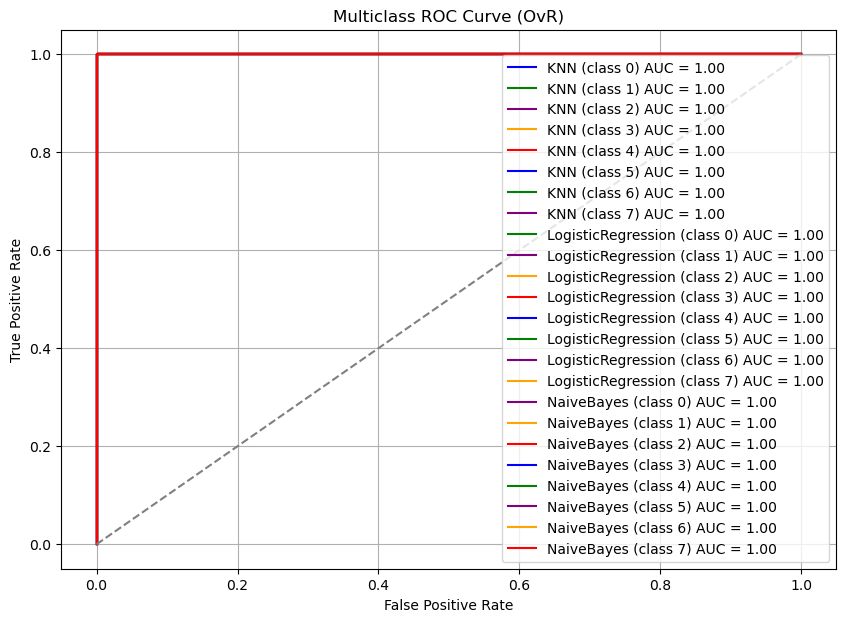

In [126]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

roc_data = {}

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

colors = ["blue", "green", "purple", "orange", "red"]

plt.figure(figsize=(10, 7))

for i, m in enumerate(models):
    model = fit_classification_model(m, y_train, X_train)
    y_prob = model.predict_proba(X_test)

    # Compute AUC using all class probabilities
    auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
    
    # Plot ROC curve for each class
    for j in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, j], y_prob[:, j])
        plt.plot(
            fpr,
            tpr,
            label=f"{m} (class {classes[j]}) AUC = {roc_auc_score(y_test_bin[:, j], y_prob[:, j]):.2f}",
            color=colors[(i + j) % len(colors)]
        )

plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (OvR)")
plt.legend()
plt.grid(True)
plt.show()


In [127]:
auc_per_class = {}

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

for m in models:
    model = fit_classification_model(m, y_train, X_train)
    y_prob = model.predict_proba(X_test)

    auc_per_class[m] = {}
    for j, class_label in enumerate(classes):
        auc = roc_auc_score(y_test_bin[:, j], y_prob[:, j])
        auc_per_class[m][class_label] = auc

for m in models:
    print(f"\nAUC for model: {m}")
    for class_label, auc in auc_per_class[m].items():
        print(f"  Class {class_label}: AUC = {auc:.2f}")



AUC for model: KNN
  Class 0: AUC = 1.00
  Class 1: AUC = 1.00
  Class 2: AUC = 1.00
  Class 3: AUC = 1.00
  Class 4: AUC = 1.00
  Class 5: AUC = 1.00
  Class 6: AUC = 1.00
  Class 7: AUC = 1.00

AUC for model: LogisticRegression
  Class 0: AUC = 1.00
  Class 1: AUC = 1.00
  Class 2: AUC = 1.00
  Class 3: AUC = 1.00
  Class 4: AUC = 1.00
  Class 5: AUC = 1.00
  Class 6: AUC = 1.00
  Class 7: AUC = 1.00

AUC for model: NaiveBayes
  Class 0: AUC = 1.00
  Class 1: AUC = 1.00
  Class 2: AUC = 1.00
  Class 3: AUC = 1.00
  Class 4: AUC = 1.00
  Class 5: AUC = 1.00
  Class 6: AUC = 1.00
  Class 7: AUC = 1.00


### Multinomial Classification Model - Smaller Classes

In [128]:
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

conditions = [
    df['Addiction Level'] <= 1,              
    df['Addiction Level'].between(2, 3), 
    df['Addiction Level'].between(4, 5),
    df['Addiction Level'] >= 6               
]

choices = [0, 1, 2, 3]  

df['Addiction Level'] = np.select(conditions, choices)

X = df.drop(columns=["Addiction Level"])
y = df["Addiction Level"]

def standardize_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X_scaled

standardized_X = standardize_data(X)

X_train, X_test, y_train, y_test = train_test_split(standardized_X, y, test_size=0.2, random_state=100, shuffle=True)

In [129]:
models = ["KNN", "LogisticRegression", "NaiveBayes"]
metrics = ["accuracy", "precision", "recall"]

results = pd.DataFrame(index=models, columns=metrics)

for m in models:
    model = fit_classification_model(m,y_train,X_train)
    y_pred = model.predict(X_test)

    results.loc[m, "accuracy"] = accuracy_score(y_test, y_pred)
    results.loc[m, "precision"] = precision_score(y_test, y_pred, average='weighted')
    results.loc[m, "recall"] = recall_score(y_test, y_pred, average='weighted')
    
print(results)

                   accuracy precision recall
KNN                     0.8  0.804912    0.8
LogisticRegression     0.97  0.969741   0.97
NaiveBayes             0.96  0.962907   0.96


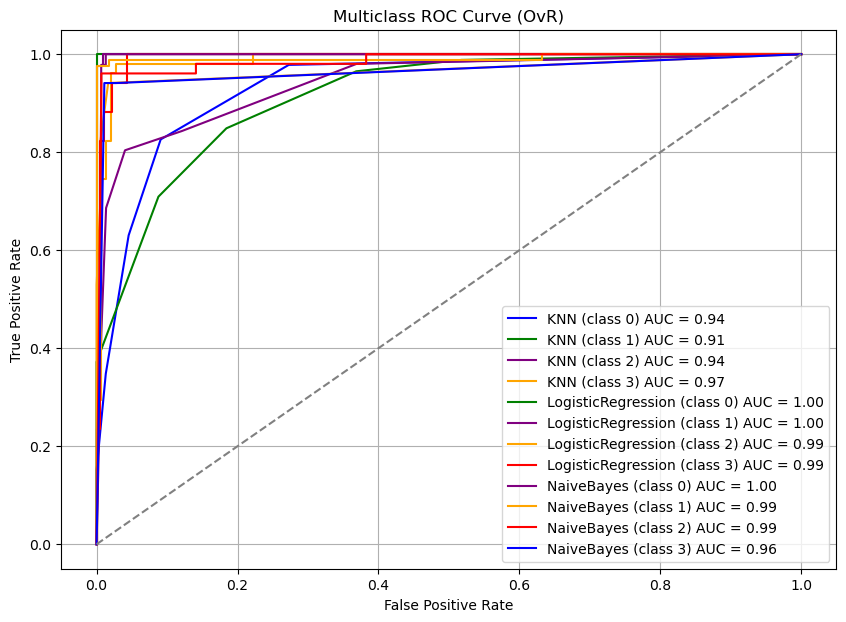

In [130]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

roc_data = {}

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

colors = ["blue", "green", "purple", "orange", "red"]

plt.figure(figsize=(10, 7))

for i, m in enumerate(models):
    model = fit_classification_model(m, y_train, X_train)
    y_prob = model.predict_proba(X_test)

    # Compute AUC using all class probabilities
    auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
    
    # Plot ROC curve for each class
    for j in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, j], y_prob[:, j])
        plt.plot(
            fpr,
            tpr,
            label=f"{m} (class {classes[j]}) AUC = {roc_auc_score(y_test_bin[:, j], y_prob[:, j]):.2f}",
            color=colors[(i + j) % len(colors)]
        )

plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (OvR)")
plt.legend()
plt.grid(True)
plt.show()


In [131]:
auc_per_class = {}

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

for m in models:
    model = fit_classification_model(m, y_train, X_train)
    y_prob = model.predict_proba(X_test)

    auc_per_class[m] = {}
    for j, class_label in enumerate(classes):
        auc = roc_auc_score(y_test_bin[:, j], y_prob[:, j])
        auc_per_class[m][class_label] = auc

for m in models:
    print(f"\nAUC for model: {m}")
    for class_label, auc in auc_per_class[m].items():
        print(f"  Class {class_label}: AUC = {auc:.2f}")



AUC for model: KNN
  Class 0: AUC = 0.94
  Class 1: AUC = 0.91
  Class 2: AUC = 0.94
  Class 3: AUC = 0.97

AUC for model: LogisticRegression
  Class 0: AUC = 1.00
  Class 1: AUC = 1.00
  Class 2: AUC = 0.99
  Class 3: AUC = 0.99

AUC for model: NaiveBayes
  Class 0: AUC = 1.00
  Class 1: AUC = 0.99
  Class 2: AUC = 0.99
  Class 3: AUC = 0.96


### Multinomial Smaller Class but Correlated Features

In [132]:
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

conditions = [
    df['Addiction Level'] <= 1,              
    df['Addiction Level'].between(2, 3), 
    df['Addiction Level'].between(4, 5),
    df['Addiction Level'] >= 6               
]

choices = [0, 1, 2, 3]  

df['Addiction Level'] = np.select(conditions, choices)

df_full = df[['Time of Day_Morning', 'Time of Day_Night', 'Watch Hour', 'ProductivityLoss', 'Satisfaction', 'Self Control', 'Addiction Level']]

X = df_full.drop('Addiction Level', axis = 1)
y = df_full['Addiction Level']

def standardize_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X_scaled

standardized_X = standardize_data(X)

X_train, X_test, y_train, y_test = train_test_split(standardized_X, y, test_size=0.2, random_state=100, shuffle=True)

In [133]:
models = ["KNN", "LogisticRegression", "NaiveBayes"]
metrics = ["accuracy", "precision", "recall"]

results = pd.DataFrame(index=models, columns=metrics)

for m in models:
    model = fit_classification_model(m,y_train,X_train)
    y_pred = model.predict(X_test)

    results.loc[m, "accuracy"] = accuracy_score(y_test, y_pred)
    results.loc[m, "precision"] = precision_score(y_test, y_pred, average='weighted')
    results.loc[m, "recall"] = recall_score(y_test, y_pred, average='weighted')
    
print(results)

                   accuracy precision recall
KNN                     1.0       1.0    1.0
LogisticRegression      1.0       1.0    1.0
NaiveBayes             0.99  0.991053   0.99


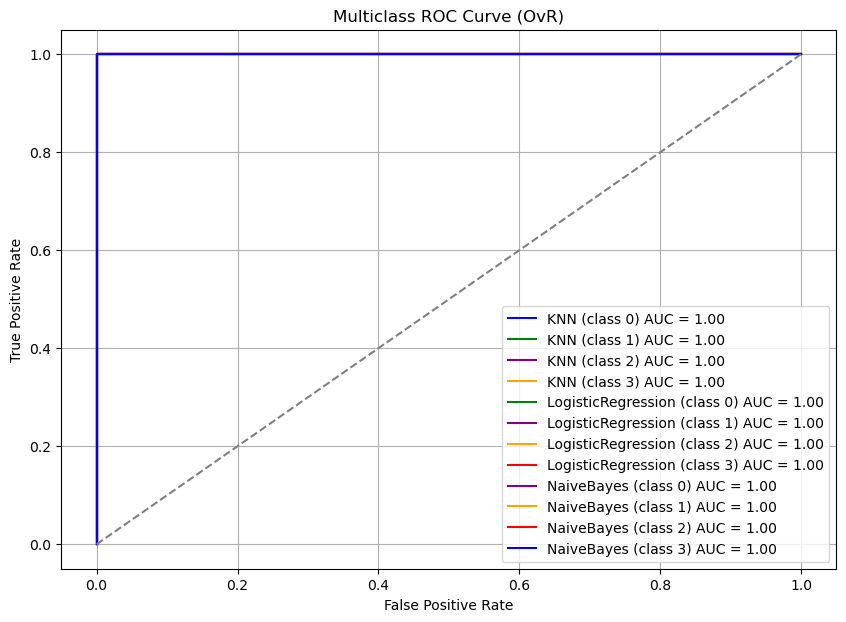

In [134]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

roc_data = {}

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

colors = ["blue", "green", "purple", "orange", "red"]

plt.figure(figsize=(10, 7))

for i, m in enumerate(models):
    model = fit_classification_model(m, y_train, X_train)
    y_prob = model.predict_proba(X_test)

    # Compute AUC using all class probabilities
    auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
    
    # Plot ROC curve for each class
    for j in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, j], y_prob[:, j])
        plt.plot(
            fpr,
            tpr,
            label=f"{m} (class {classes[j]}) AUC = {roc_auc_score(y_test_bin[:, j], y_prob[:, j]):.2f}",
            color=colors[(i + j) % len(colors)]
        )

plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (OvR)")
plt.legend()
plt.grid(True)
plt.show()


In [135]:
auc_per_class = {}

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

for m in models:
    model = fit_classification_model(m, y_train, X_train)
    y_prob = model.predict_proba(X_test)

    auc_per_class[m] = {}
    for j, class_label in enumerate(classes):
        auc = roc_auc_score(y_test_bin[:, j], y_prob[:, j])
        auc_per_class[m][class_label] = auc

for m in models:
    print(f"\nAUC for model: {m}")
    for class_label, auc in auc_per_class[m].items():
        print(f"  Class {class_label}: AUC = {auc:.2f}")



AUC for model: KNN
  Class 0: AUC = 1.00
  Class 1: AUC = 1.00
  Class 2: AUC = 1.00
  Class 3: AUC = 1.00

AUC for model: LogisticRegression
  Class 0: AUC = 1.00
  Class 1: AUC = 1.00
  Class 2: AUC = 1.00
  Class 3: AUC = 1.00

AUC for model: NaiveBayes
  Class 0: AUC = 1.00
  Class 1: AUC = 1.00
  Class 2: AUC = 1.00
  Class 3: AUC = 1.00


### Binary Classification Problem - All variables

In [136]:
df = pd.read_csv("data_clean.csv")
df['Addiction Status'] = np.where(df['Addiction Level'] <= 4, 0, 1)
df.drop(['Watch Time', 'Addiction Level'], axis = 1, inplace=True)
df = pd.get_dummies(df, drop_first=True, dtype = int)

def standardize_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X_scaled

In [137]:
X = df.drop(columns=["Addiction Status"])
y = df["Addiction Status"]
standardized_X = standardize_data(X)

X_train, X_test, y_train, y_test = train_test_split(standardized_X, y, test_size=0.2, random_state=100, shuffle=True)

In [138]:
def fit_classification_model(m, y, X) -> float:
    # This function was implemented with type overriding of both a model and a model name
    if isinstance(m, str):
        if m == "KNN":
            m = KNeighborsClassifier(5)
        elif m == "LogisticRegression":
            m = LogisticRegression(max_iter=10000)
        elif m == "NaiveBayes":
            m = GaussianNB()

    return m.fit(X, y)

In [139]:
models = ["KNN", "LogisticRegression", "NaiveBayes"]
metrics = ["accuracy", "precision", "recall"]

results = pd.DataFrame(index=models, columns=metrics)

for m in models:
    model = fit_classification_model(m,y_train,X_train)
    y_pred = model.predict(X_test)

    results.loc[m, "accuracy"] = accuracy_score(y_test, y_pred)
    results.loc[m, "precision"] = precision_score(y_test, y_pred, pos_label=1)
    results.loc[m, "recall"] = recall_score(y_test, y_pred, pos_label=1)
    
    if m == "LogisticRegression":
        print('Logistic Regression Coefficients:', model.coef_)
    
print(results)

Logistic Regression Coefficients: [[-1.24938380e-01  9.05794366e-02 -1.59942103e-01 -1.98063828e-03
  -1.13559127e-01  7.46450196e-02  1.15873913e-01  4.64241326e-02
  -1.26037221e-01 -2.21290487e-02 -1.57268012e-02  1.25353197e-02
  -6.41092926e-02 -2.68285438e+00  2.68285438e+00 -2.78281677e+00
   7.44033401e-01  1.88500150e-02 -1.32416424e-01  6.93671092e-02
  -1.56599367e-02 -1.10957379e-01 -1.80989678e-01  1.90666721e-02
   5.53839144e-02  2.46005934e-01  3.60783309e-01  1.02733508e-01
  -4.97157780e-02  2.75881196e-02 -4.52780017e-02  3.46337661e-02
  -2.43289732e-01  1.06649690e-01  1.58995410e-01 -1.42796171e-01
   1.88095337e-01  6.44343316e-02 -6.69798076e-02 -9.69553678e-02
   1.49289143e-02 -1.47016692e-01  5.12966235e-02  5.57962764e-04
  -6.86922108e-02  4.91669941e-02  1.59806350e-01  8.11000901e-02
   9.09893006e-02  2.37884446e-01  1.11424512e-01 -1.40836455e-01
  -2.32382517e-01  2.00897495e-01  7.66755181e-04  5.50864260e-02
   1.18536044e-01  1.48350154e-01 -1.20918

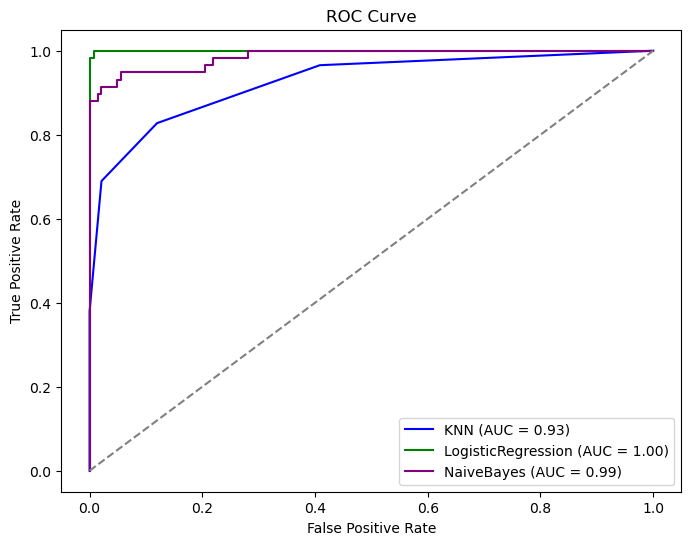

In [140]:
roc_data = {}
for m in models:
    model = fit_classification_model(m, y_train, X_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

    roc_data[m] = {
        "auc": auc,
        "fpr": fpr,
        "tpr": tpr,
    }

colors = ["blue", "green", "purple"]
# plot ROC curve of all models
plt.figure(figsize=(8, 6))
for i, m in enumerate(models):
    plt.plot(
        roc_data[m]["fpr"],
        roc_data[m]["tpr"],
        label=f"{m} (AUC = {roc_data[m]['auc']:.2f})",
        color=colors[i],
    )
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [141]:
results["auc"] = [roc_data[m]["auc"] for m in models]
print(results)

                   accuracy precision    recall       auc
KNN                   0.895  0.930233  0.689655  0.926299
LogisticRegression     0.99  0.982759  0.982759  0.999879
NaiveBayes            0.945  0.898305  0.913793  0.985430


### Binary Classification Problem - Correlated Metrics

In [142]:
df = pd.read_csv("data_clean.csv")
df['Addiction Status'] = np.where(df['Addiction Level'] <= 4, 0, 1)
df = pd.get_dummies(df, drop_first=True, dtype = int)
df.drop('Addiction Level', axis = 1, inplace=True)

df_full = df[['Time of Day_Morning', 'Time of Day_Night', 'Watch Hour', 'ProductivityLoss', 'Satisfaction', 'Self Control', 'Addiction Status']]
X = df_full.drop('Addiction Status', axis = 1)
y = df_full['Addiction Status']

standardized_data = standardize_data(X)

X_train, X_test, y_train, y_test = train_test_split(standardized_data, y, test_size=0.2, random_state=100, shuffle=True)

In [143]:
def fit_classification_model(m, y, X) -> float:
    # This function was implemented with type overriding of both a model and a model name
    if isinstance(m, str):
        if m == "KNN":
            m = KNeighborsClassifier(5)
        elif m == "LogisticRegression":
            m = LogisticRegression(max_iter=10000)
        elif m == "NaiveBayes":
            m = GaussianNB()

    return m.fit(X, y)

In [144]:
models = ["KNN", "LogisticRegression", "NaiveBayes"]
metrics = ["accuracy", "precision", "recall"]

results = pd.DataFrame(index=models, columns=metrics)

for m in models:
    model = fit_classification_model(m,y_train,X_train)
    y_pred = model.predict(X_test)

    results.loc[m, "accuracy"] = accuracy_score(y_test, y_pred)
    results.loc[m, "precision"] = precision_score(y_test, y_pred, pos_label=1)
    results.loc[m, "recall"] = recall_score(y_test, y_pred, pos_label=1)

    if m == "LogisticRegression":
        print('Logistic Regression Coefficients:', model.coef_)
    
print(results)

Logistic Regression Coefficients: [[ 0.42234998  0.99645099  0.21187648 -2.90266473  2.90266473 -3.00064098]]
                   accuracy precision    recall
KNN                     1.0       1.0       1.0
LogisticRegression      1.0       1.0       1.0
NaiveBayes             0.99       1.0  0.965517


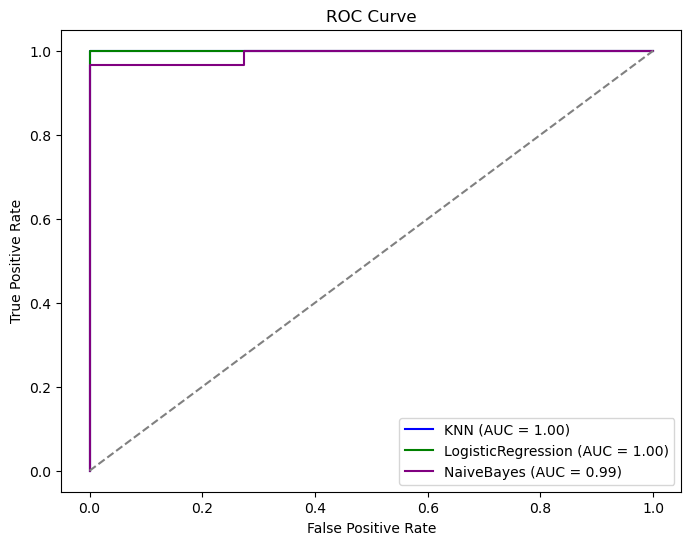

In [145]:
roc_data = {}
for m in models:
    model = fit_classification_model(m, y_train, X_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

    roc_data[m] = {
        "auc": auc,
        "fpr": fpr,
        "tpr": tpr,
    }

colors = ["blue", "green", "purple"]
# plot ROC curve of all models
plt.figure(figsize=(8, 6))
for i, m in enumerate(models):
    plt.plot(
        roc_data[m]["fpr"],
        roc_data[m]["tpr"],
        label=f"{m} (AUC = {roc_data[m]['auc']:.2f})",
        color=colors[i],
    )
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [146]:
results["auc"] = [roc_data[m]["auc"] for m in models]
print(results)

                   accuracy precision    recall       auc
KNN                     1.0       1.0       1.0  1.000000
LogisticRegression      1.0       1.0       1.0  1.000000
NaiveBayes             0.99       1.0  0.965517  0.990529


### Binary Classification Problem (Only certain metrics I think would be cool to look at)

In [147]:
# Display coefficients for the model and do hypothesis test (whether the features have a significant impact on the addiction level). Decision Trees (feature importance). Look at document posted a while ago.
# K fold cross validation for the 80% and compute error for several fold splits. Find number params. (do for all variables and select to see the minimized number of models)

In [148]:
df = pd.read_csv("data_clean.csv")
df['Addiction Status'] = np.where(df['Addiction Level'] <= 4, 0, 1)
df = pd.get_dummies(df, drop_first=True, dtype = int)

In [149]:
df_full = df[['Age', 'Total Time Spent', 'Number of Sessions', 'Time per Session', 'Engagement', 'ProductivityLoss', 'Satisfaction', 'Self Control',
          'Scroll Rate', 'Videos per Session', "Addiction Status"]]
X = df_full[['Age', 'Total Time Spent', 'Number of Sessions', 'Time per Session', 'Engagement', 'ProductivityLoss', 'Satisfaction', 'Self Control',
          'Scroll Rate', 'Vid'
          'eos per Session']]
y = df_full["Addiction Status"]

standardized_X = standardize_data(X)

X_train, X_test, y_train, y_test = train_test_split(standardized_X, y, test_size=0.2, random_state=100, shuffle=True)

/Users/victoriazbierowski/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


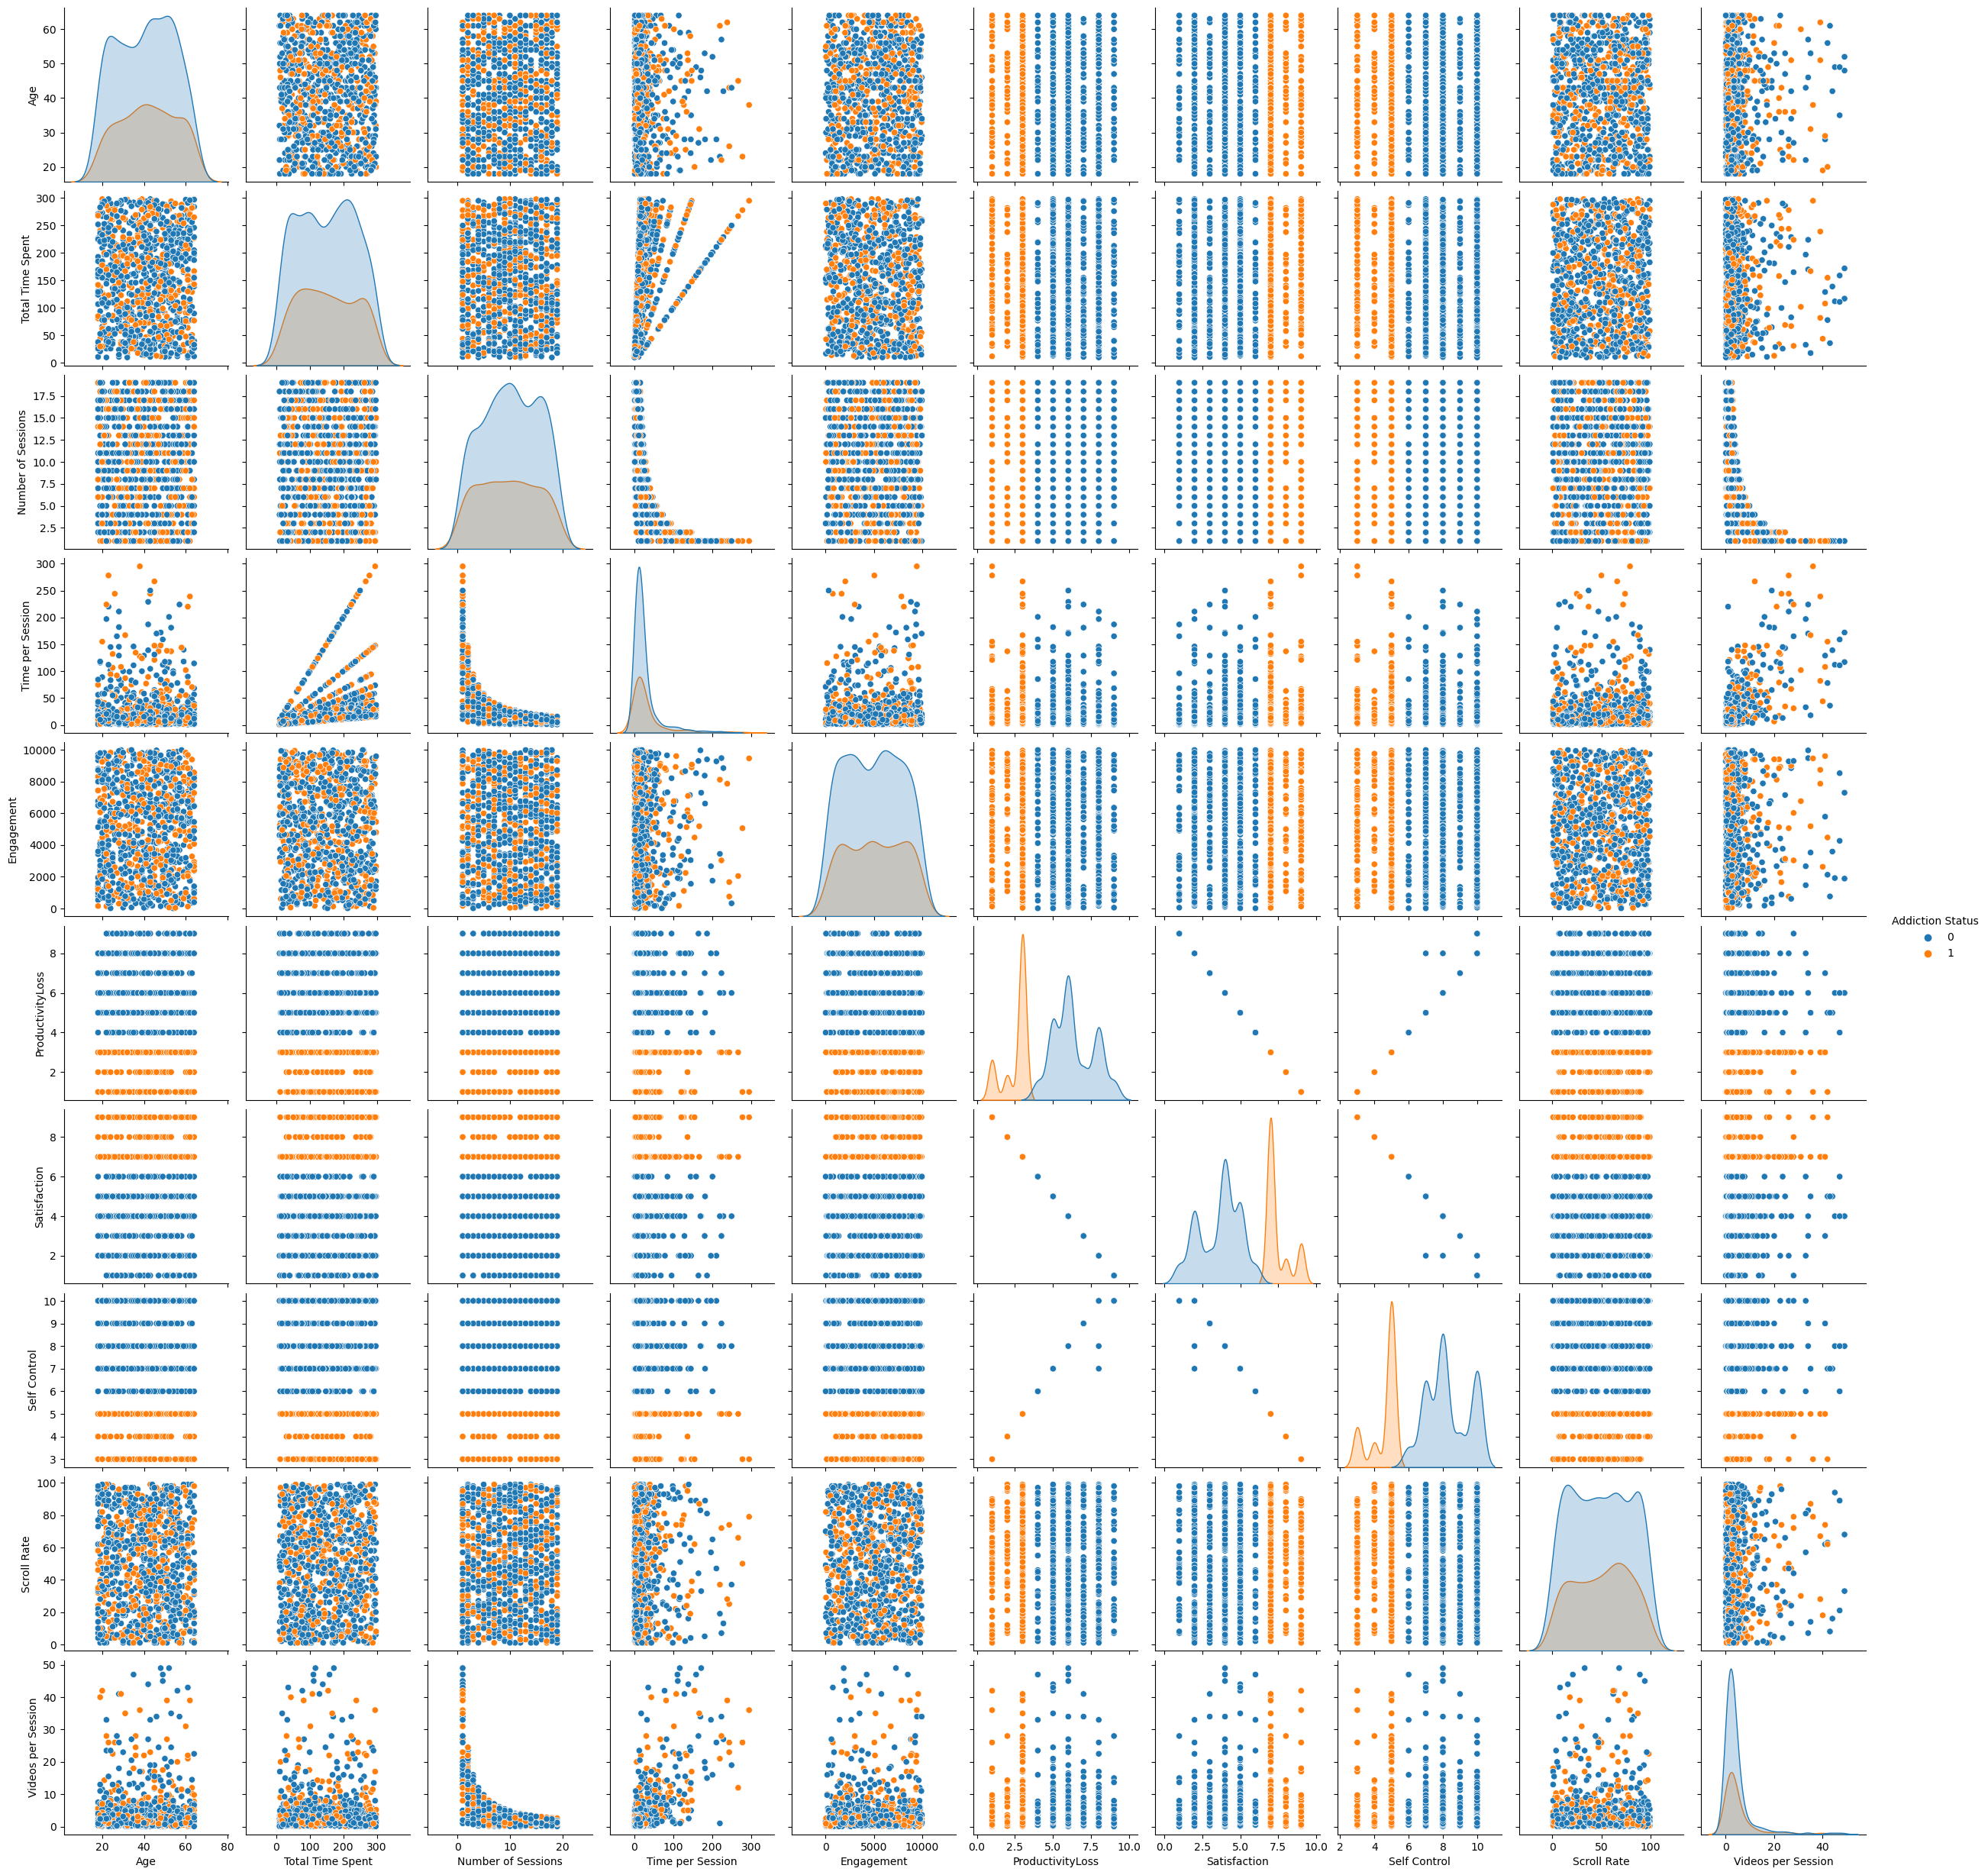

In [150]:
sns.pairplot(df_full, hue='Addiction Status')

In [151]:
def fit_classification_model(m, y, X) -> float:
    # This function was implemented with type overriding of both a model and a model name
    if isinstance(m, str):
        if m == "KNN":
            m = KNeighborsClassifier(5)
        elif m == "LogisticRegression":
            m = LogisticRegression(max_iter=10000)
        elif m == "NaiveBayes":
            m = GaussianNB()

    return m.fit(X, y)

In [152]:
models = ["KNN", "LogisticRegression", "NaiveBayes"]
metrics = ["accuracy", "precision", "recall"]

results = pd.DataFrame(index=models, columns=metrics)

for m in models:
    model = fit_classification_model(m,y_train,X_train)
    y_pred = model.predict(X_test)

    results.loc[m, "accuracy"] = accuracy_score(y_test, y_pred)
    results.loc[m, "precision"] = precision_score(y_test, y_pred, pos_label=1)
    results.loc[m, "recall"] = recall_score(y_test, y_pred, pos_label=1)

    if m == "LogisticRegression":
        print('Logistic Regression Coefficients:', model.coef_)
    
print(results)

Logistic Regression Coefficients: [[ 0.0639461   0.06791503  0.1190013  -0.04092399 -0.17566129 -3.13802389
   3.13802389 -3.28657704 -0.03494474  0.05586529]]
                   accuracy precision    recall
KNN                    0.97  0.919355  0.982759
LogisticRegression      1.0       1.0       1.0
NaiveBayes            0.965  0.892308       1.0


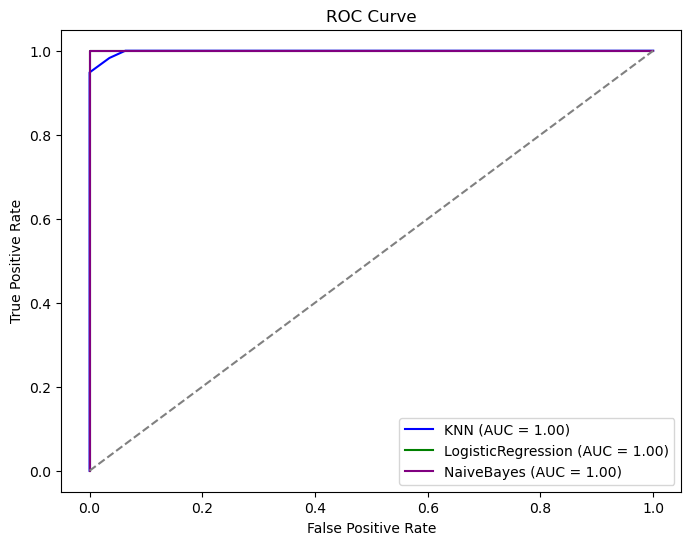

In [153]:
roc_data = {}
for m in models:
    model = fit_classification_model(m, y_train, X_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

    roc_data[m] = {
        "auc": auc,
        "fpr": fpr,
        "tpr": tpr,
    }

colors = ["blue", "green", "purple"]
# plot ROC curve of all models
plt.figure(figsize=(8, 6))
for i, m in enumerate(models):
    plt.plot(
        roc_data[m]["fpr"],
        roc_data[m]["tpr"],
        label=f"{m} (AUC = {roc_data[m]['auc']:.2f})",
        color=colors[i],
    )
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [154]:
results["auc"] = [roc_data[m]["auc"] for m in models]
print(results)

                   accuracy precision    recall       auc
KNN                    0.97  0.919355  0.982759  0.998543
LogisticRegression      1.0       1.0       1.0  1.000000
NaiveBayes            0.965  0.892308       1.0  1.000000


### Correlation Heat Map

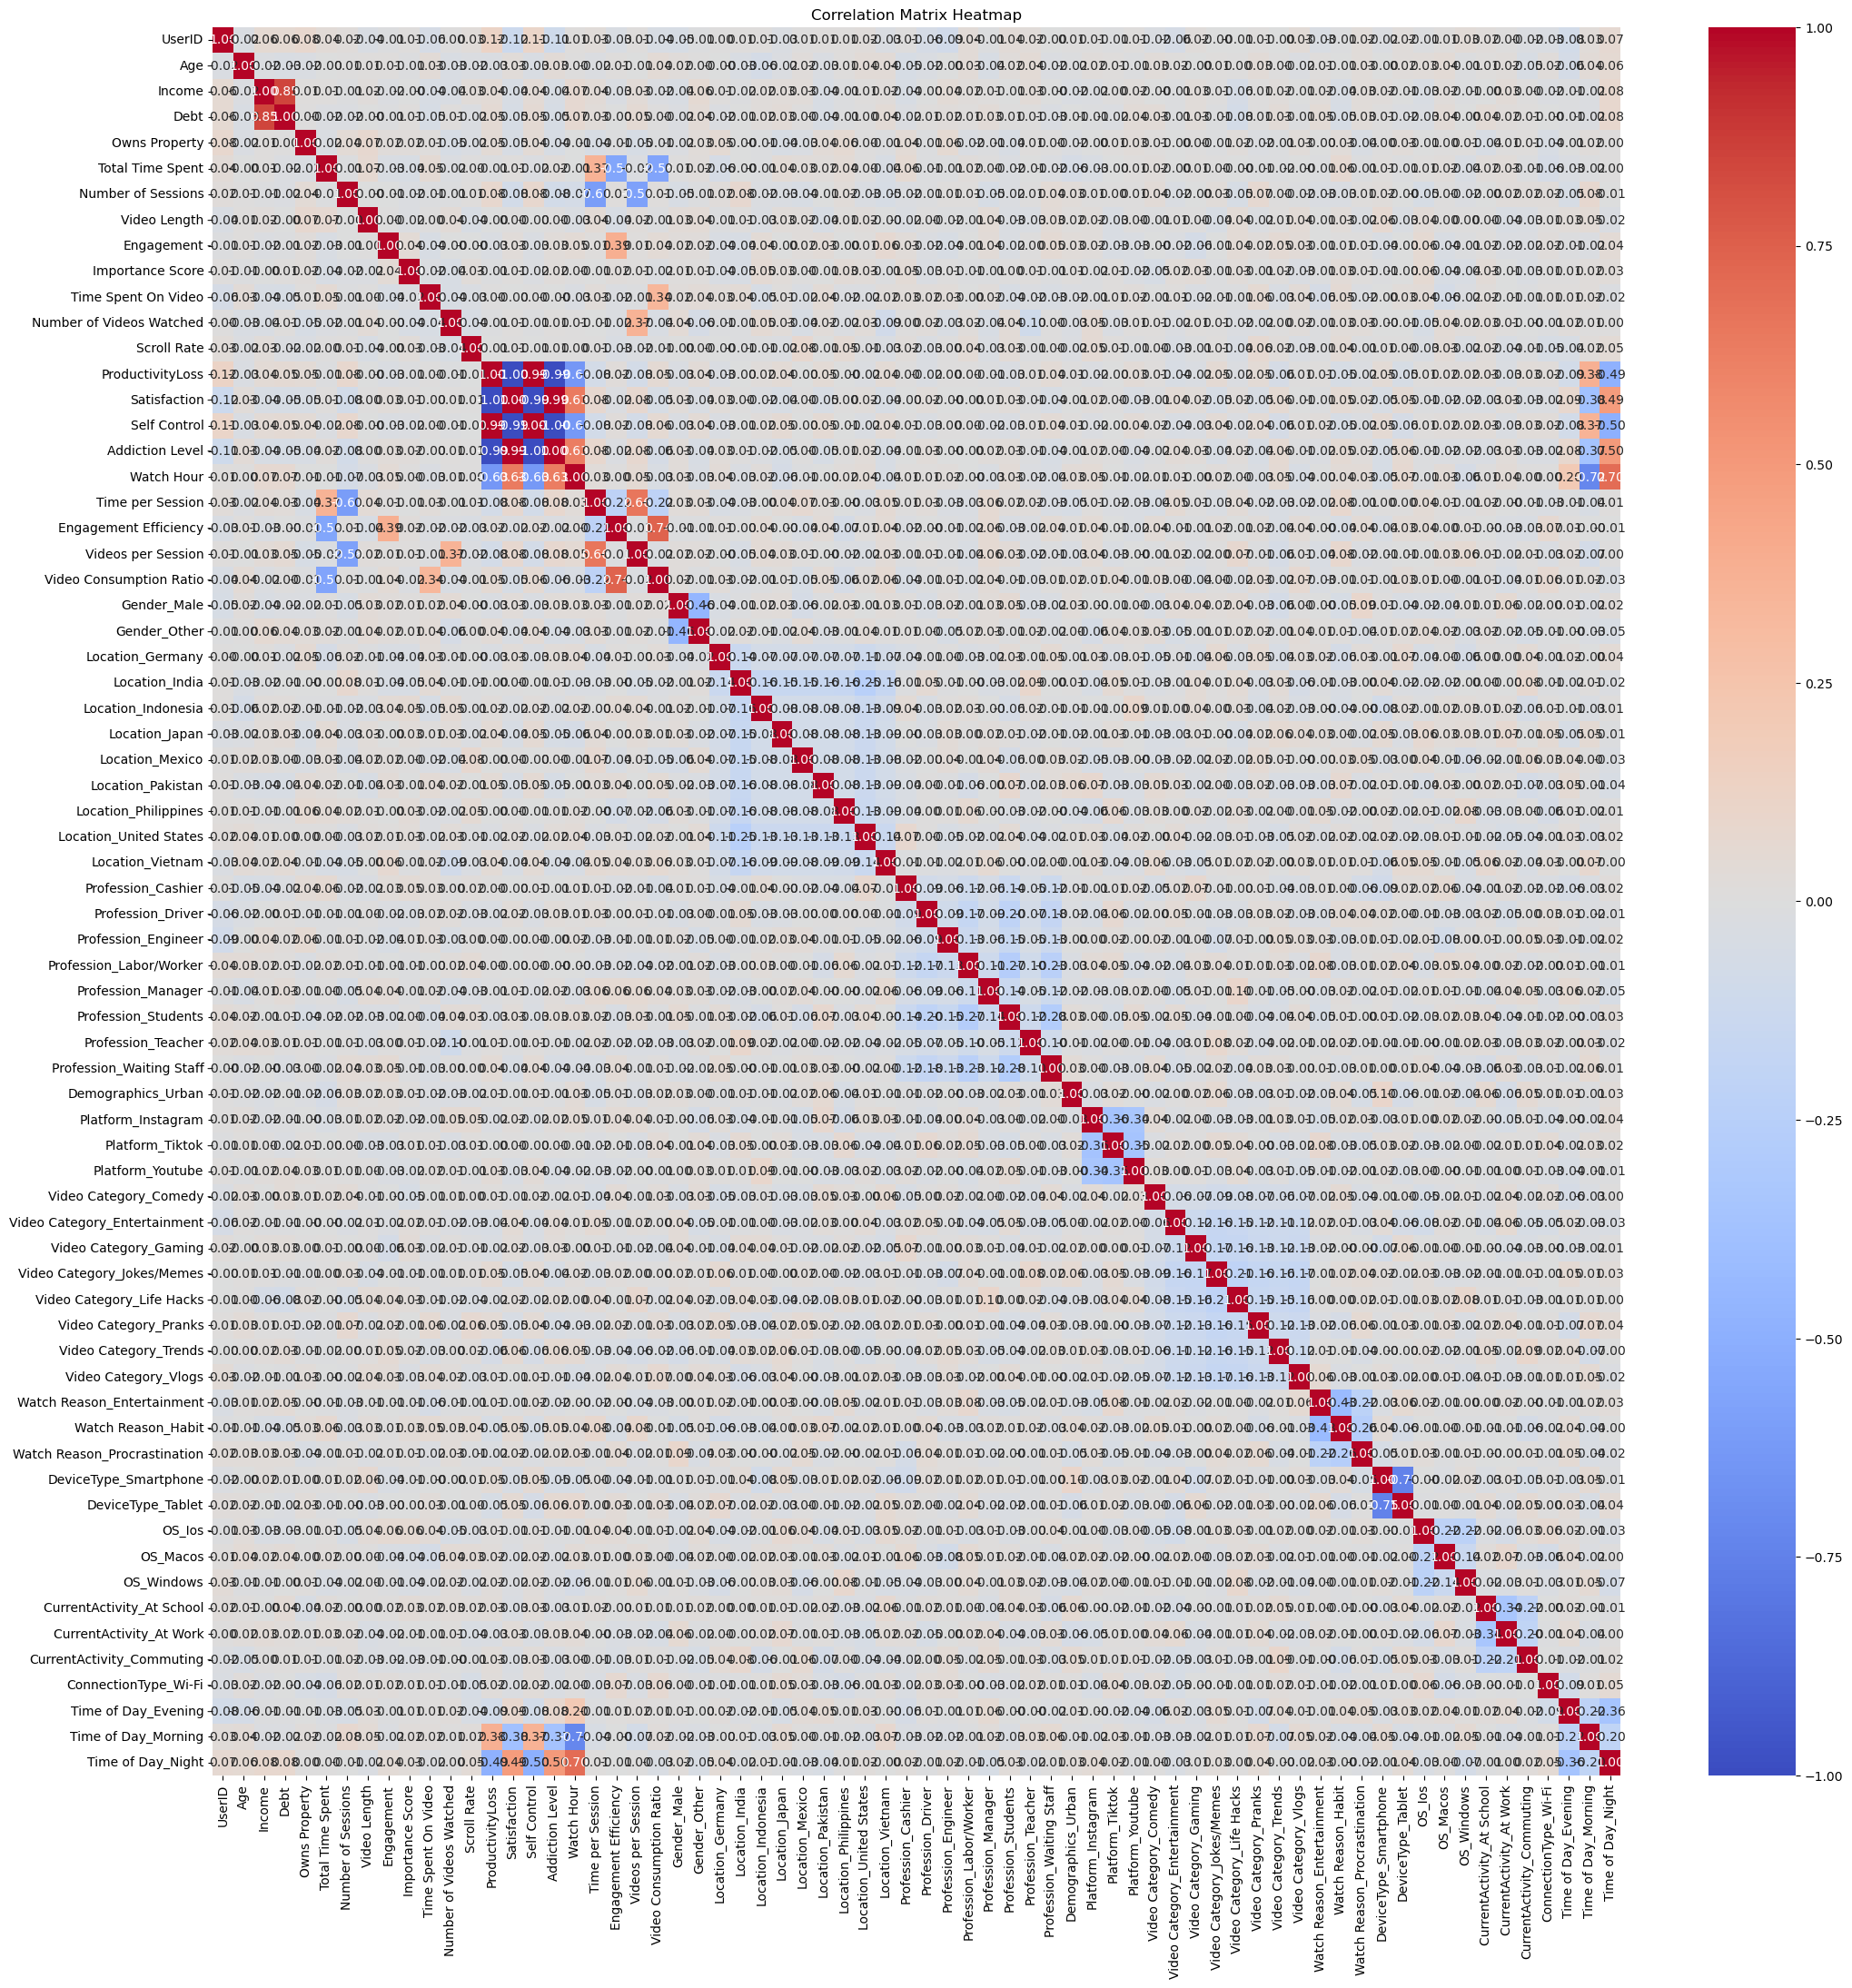

In [155]:
# Display heat map of the correlation matrix
df = pd.read_csv("data_clean.csv")
df.drop('Watch Time', axis=1, inplace=True)
df_y = df['Addiction Level']
df.drop('Addiction Level', axis = 1)
df = pd.get_dummies(df, drop_first=True, dtype = int)

standardized_data = standardize_data(df)

df['Addiction Level'] = df_y

#standardized_data = standardize_data(df)

plt.figure(figsize=(25, 25))
sns.heatmap(standardized_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

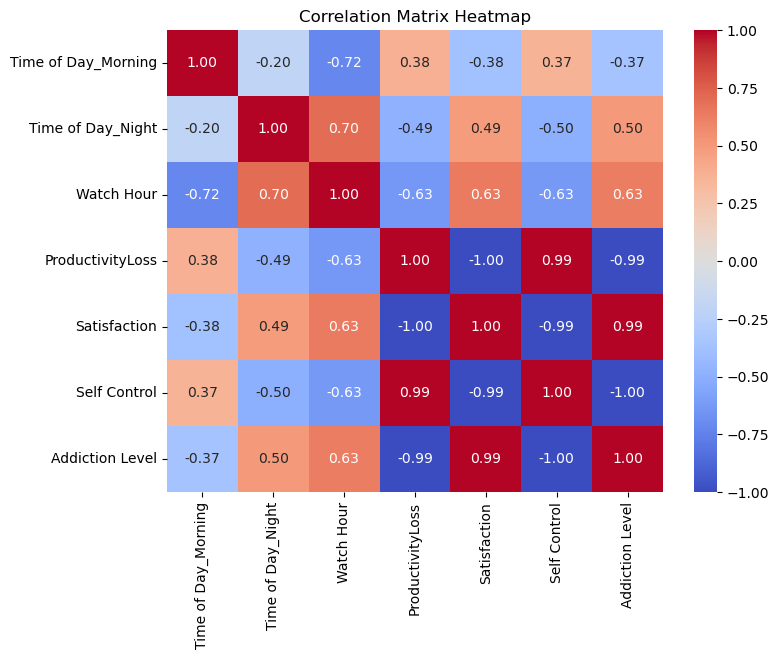

In [156]:
# Display heat map of the correlation matrix
plt.figure(figsize=(8, 6))
df_full = df[['Time of Day_Morning', 'Time of Day_Night', 'Watch Hour', 'ProductivityLoss', 'Satisfaction', 'Self Control', 'Addiction Level']]
sns.heatmap(df_full.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [157]:
print('Data points for Addiction Level = 0: ', len(df[df['Addiction Level'] == 0]))
print('Data points for Addiction Level = 1: ', len(df[df['Addiction Level'] == 1]))
print('Data points for Addiction Level = 2: ', len(df[df['Addiction Level'] == 2]))
print('Data points for Addiction Level = 3: ', len(df[df['Addiction Level'] == 3]))
print('Data points for Addiction Level = 4: ', len(df[df['Addiction Level'] == 4]))
print('Data points for Addiction Level = 5: ', len(df[df['Addiction Level'] == 5]))
print('Data points for Addiction Level = 6: ', len(df[df['Addiction Level'] == 6]))      
print('Data points for Addiction Level = 7: ', len(df[df['Addiction Level'] == 7]))    

Data points for Addiction Level = 0:  180
Data points for Addiction Level = 1:  60
Data points for Addiction Level = 2:  248
Data points for Addiction Level = 3:  159
Data points for Addiction Level = 4:  36
Data points for Addiction Level = 5:  228
Data points for Addiction Level = 6:  34
Data points for Addiction Level = 7:  55


### KFOLD Cross Validation - Logistic

In [158]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

In [177]:
# K-fold cross-validation
# def k_fold_cross_validation(X_train, y_train, k=5, verbose=True):
#     kf = KFold(n_splits=k, shuffle=True, random_state=100)
#     mse_train = []
#     mse_test = []
#     for train_index, test_index in kf.split(X_train):
#         X_train_mini, X_test_mini = X_train.iloc[train_index], X_train.iloc[test_index]
#         y_train_mini, y_test_mini = y_train.iloc[train_index], y_train.iloc[test_index]
#         model = LinearRegression()
#         model.fit(X_train_mini, y_train_mini)
#         y_pred_train_mini = model.predict(X_train_mini)
#         y_pred_test_mini = model.predict(X_test_mini)
#         mse_train.append(mean_squared_error(y_train_mini, y_pred_train_mini))
#         mse_test.append(mean_squared_error(y_test_mini, y_pred_test_mini))

#     if verbose:
#         print(f"K-Fold Cross-validation MSE Train: {mse_train}")
#         print(f"K-Fold Cross-validation MSE Test: {mse_test}")

#     return np.mean(mse_train), np.mean(mse_test)

def k_fold_cross_validation(X_train, y_train, k=5, verbose=True):
    kf = KFold(n_splits=k, shuffle=True, random_state=100)
    mse_train = []
    mse_test = []
    for train_index, test_index in kf.split(X_train):
        X_train_mini, X_test_mini = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_mini, y_test_mini = y_train.iloc[train_index], y_train.iloc[test_index]
        model = LogisticRegression(max_iter=100000)
        model.fit(X_train_mini, y_train_mini)
        y_pred_train_mini = model.predict(X_train_mini)
        y_pred_test_mini = model.predict(X_test_mini)
        mse_train.append(mean_squared_error(y_train_mini, y_pred_train_mini))
        mse_test.append(mean_squared_error(y_test_mini, y_pred_test_mini))

    if verbose:
        mean_train = np.mean(mse_train)
        mean_test = np.mean(mse_test)
        print(f"Average K-Fold Cross-validation MSE Train: {mean_train}")
        print(f"Average K-Fold Cross-validation MSE Test: {mean_test}")

    return mean_train, mean_test

def create_polynomial_features(X, degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    X_poly = pd.DataFrame(
        X_poly,
        columns=poly.get_feature_names_out(X.columns),
        index=X.index,
    )
    return X_poly

def standardize_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X_scaled

In [178]:
# KFOLD CROSS VALIDATION FOR ALL VARIABLES (MULTINOMIAL)
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

X = df.drop(columns=["Addiction Level"])
y = df["Addiction Level"]

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 0.0
Average K-Fold Cross-validation MSE Test: 0.64625
0.0 0.64625


In [183]:
# KFOLD CROSS VALIDATION FOR CORRELATED FEATURES (MULTINOMIAL)
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

df_full = df[['Time of Day_Morning', 'Time of Day_Night', 'Watch Hour', 'ProductivityLoss', 'Satisfaction', 'Self Control', 'Addiction Level']]
X = df_full.drop('Addiction Level', axis = 1)
y = df_full['Addiction Level']

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 0.0171875
Average K-Fold Cross-validation MSE Test: 0.03125
0.0171875 0.03125


In [182]:
# KFOLD CROSS VALIDATION FOR ALL VARIABLES (MULTINOMIAL) SMALL CLASSES
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

conditions = [
    df['Addiction Level'] <= 1,              
    df['Addiction Level'].between(2, 3), 
    df['Addiction Level'].between(4, 5),
    df['Addiction Level'] >= 6               
]

choices = [0, 1, 2, 3]  

df['Addiction Level'] = np.select(conditions, choices)

X = df.drop(columns=["Addiction Level"])
y = df["Addiction Level"]

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 0.0
Average K-Fold Cross-validation MSE Test: 0.12375
0.0 0.12375


In [180]:
# KFOLD CROSS VALIDATION FOR CORRELATED VARIABLES (MULTINOMIAL) SMALL CLASSES
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

conditions = [
    df['Addiction Level'] <= 1,              
    df['Addiction Level'].between(2, 3), 
    df['Addiction Level'].between(4, 5),
    df['Addiction Level'] >= 6               
]

choices = [0, 1, 2, 3]  

df['Addiction Level'] = np.select(conditions, choices)

df_full = df[['Time of Day_Morning', 'Time of Day_Night', 'Watch Hour', 'ProductivityLoss', 'Satisfaction', 'Self Control', 'Addiction Level']]

X = df_full.drop('Addiction Level', axis = 1)
y = df_full['Addiction Level']

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 0.00125
Average K-Fold Cross-validation MSE Test: 0.0025
0.00125 0.0025


In [184]:
# KFOLD CROSS VALIDATION FOR ALL VARIABLES (BINARY PREDICTOR)
df = pd.read_csv("data_clean.csv")
df['Addiction Status'] = np.where(df['Addiction Level'] <= 4, 0, 1)
df = pd.get_dummies(df, drop_first=True, dtype = int)

X = df.drop(columns=["Addiction Level", "Addiction Status"])
y = df["Addiction Status"]

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

# For this one, train MSE very very low, meaning it could be a sign of overfitting.
# Test is much higher, meaning that the model is not as prepared for new data.

# find average of all the test and train errors. If model 1 has lower MSE than model 2, then it would be a better  model

Average K-Fold Cross-validation MSE Train: 0.0
Average K-Fold Cross-validation MSE Test: 0.02125
0.0 0.02125


In [165]:
pd.crosstab(df['Self Control'], df['Addiction Status'])

Addiction Status    0    1
Self Control              
3                   0   55
4                   0   34
5                   0  228
6                  36    0
7                 159    0
8                 248    0
9                  60    0
10                180    0

In [166]:
pd.crosstab(df['ProductivityLoss'], df['Addiction Status'])

Addiction Status    0    1
ProductivityLoss          
1                   0   55
2                   0   34
3                   0  228
4                  36    0
5                 158    0
6                 247    0
7                  60    0
8                 145    0
9                  37    0

In [167]:
pd.crosstab(df['Satisfaction'], df['Addiction Status'])

Addiction Status    0    1
Satisfaction              
1                  37    0
2                 145    0
3                  60    0
4                 247    0
5                 158    0
6                  36    0
7                   0  228
8                   0   34
9                   0   55

In [168]:
X = sm.add_constant(X)
model = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit_regularized(alpha=1.0, L1_wt=0.0) 

/Users/victoriazbierowski/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/victoriazbierowski/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
/Users/victoriazbierowski/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


In [169]:
def standardize_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X_scaled

standardized_X = standardize_data(X)

mymodel = LogisticRegression(max_iter=1000000)
mymodel.fit(standardized_X, y)

LogisticRegression(max_iter=1000000)

In [170]:
import statsmodels.api as sm

standardized_X = standardize_data(X)

model = sm.Logit(y, sm.add_constant(standardized_X)).fit(method='bfgs', disp=0, maxiter=1000000)

print(model.summary())

                           Logit Regression Results                           
Dep. Variable:       Addiction Status   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      922
Method:                           MLE   Df Model:                           77
Date:                Fri, 11 Apr 2025   Pseudo R-squ.:                   1.000
Time:                        08:26:52   Log-Likelihood:             -0.0011911
converged:                       True   LL-Null:                       -624.59
Covariance Type:            nonrobust   LLR p-value:                4.786e-211
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -39.4415        nan        nan        nan         nan         nan
const                                 0        nan        nan        nan     

/Users/victoriazbierowski/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [185]:
# KFOLD CROSS VALIDATION FOR SOME VARIABLES (BINARY PREDICTOR)
df = pd.read_csv("data_clean.csv")
df['Addiction Status'] = np.where(df['Addiction Level'] <= 4, 0, 1)

df_full = df[['Age', 'Total Time Spent', 'Number of Sessions', 'Time per Session', 'Engagement', 'ProductivityLoss', 'Satisfaction', 'Self Control',
          'Scroll Rate', 'Videos per Session', "Addiction Status"]]
X = df_full[['Age', 'Total Time Spent', 'Number of Sessions', 'Time per Session', 'Engagement', 'ProductivityLoss', 'Satisfaction', 'Self Control',
          'Scroll Rate', 'Videos per Session']]
y = df_full["Addiction Status"]

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

# The train and test MSE's are fairly consistent, implying that the ML model is learning about the same and performing roughly the same
# for various splits. Train obvi higher than test, but makes sense.

Average K-Fold Cross-validation MSE Train: 0.0
Average K-Fold Cross-validation MSE Test: 0.0025
0.0 0.0025


In [172]:
standardized_X = standardize_data(X)

model = sm.Logit(y, sm.add_constant(standardized_X)).fit(method='bfgs', disp=0, maxiter=1000000)

print(model.summary())

                           Logit Regression Results                           
Dep. Variable:       Addiction Status   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      990
Method:                           MLE   Df Model:                            9
Date:                Fri, 11 Apr 2025   Pseudo R-squ.:                   1.000
Time:                        08:26:52   Log-Likelihood:             -0.0034448
converged:                       True   LL-Null:                       -624.59
Covariance Type:            nonrobust   LLR p-value:                2.938e-263
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -88.8036        nan        nan        nan         nan         nan
Age                    1.9264        nan        nan        nan         nan         nan
Total Time Spent    

/Users/victoriazbierowski/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [187]:
# KFOLD CROSS VALIDATION FOR SIGNIFICANT VARIABLES (BINARY PREDICTOR)
df = pd.read_csv("data_clean.csv")
df['Addiction Status'] = np.where(df['Addiction Level'] <= 4, 0, 1)
df = pd.get_dummies(df, drop_first=True, dtype = int)
df.drop('Addiction Level', axis = 1, inplace=True)

df_full = df[['Time of Day_Morning', 'Time of Day_Night', 'Watch Hour', 'ProductivityLoss', 'Satisfaction', 'Self Control', 'Addiction Status']]
X = df_full.drop('Addiction Status', axis = 1)
y = df_full['Addiction Status']

X_train, X_test, y_train, y_test = train_test_split(df_full, y, test_size=0.2, random_state=100, shuffle=True)
X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 0.0
Average K-Fold Cross-validation MSE Test: 0.0
0.0 0.0


In [174]:
standardized_X = standardize_data(X)

model = sm.Logit(y, sm.add_constant(standardized_X)).fit(method='bfgs', disp=0, maxiter=1000000)

print(model.summary())

                           Logit Regression Results                           
Dep. Variable:       Addiction Status   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      994
Method:                           MLE   Df Model:                            5
Date:                Fri, 11 Apr 2025   Pseudo R-squ.:                   1.000
Time:                        08:26:53   Log-Likelihood:              -0.011384
converged:                       True   LL-Null:                       -624.59
Covariance Type:            nonrobust   LLR p-value:                6.620e-268
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -22.8799        nan        nan        nan         nan         nan
Time of Day_Morning     7.2319        nan        nan        nan         nan         nan
Time of Day_Nigh

/Users/victoriazbierowski/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


### KFOLD CROSS VALIDATION KNN

In [194]:
def k_fold_cross_validation(X_train, y_train, k=5, verbose=True):
    kf = KFold(n_splits=k, shuffle=True, random_state=100)
    mse_train = []
    mse_test = []
    for train_index, test_index in kf.split(X_train):
        X_train_mini, X_test_mini = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_mini, y_test_mini = y_train.iloc[train_index], y_train.iloc[test_index]
        model = KNeighborsClassifier()
        model.fit(X_train_mini, y_train_mini)
        y_pred_train_mini = model.predict(X_train_mini)
        y_pred_test_mini = model.predict(X_test_mini)
        mse_train.append(mean_squared_error(y_train_mini, y_pred_train_mini))
        mse_test.append(mean_squared_error(y_test_mini, y_pred_test_mini))

    if verbose:
        mean_train = np.mean(mse_train)
        mean_test = np.mean(mse_test)
        print(f"Average K-Fold Cross-validation MSE Train: {mean_train}")
        print(f"Average K-Fold Cross-validation MSE Test: {mean_test}")

    return mean_train, mean_test

def create_polynomial_features(X, degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    X_poly = pd.DataFrame(
        X_poly,
        columns=poly.get_feature_names_out(X.columns),
        index=X.index,
    )
    return X_poly

def standardize_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X_scaled

In [195]:
# KFOLD CROSS VALIDATION FOR ALL VARIABLES (MULTINOMIAL)
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

X = df.drop(columns=["Addiction Level"])
y = df["Addiction Level"]

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 1.7259375
Average K-Fold Cross-validation MSE Test: 2.9487499999999995
1.7259375 2.9487499999999995


In [196]:
# KFOLD CROSS VALIDATION FOR CORRELATED FEATURES (MULTINOMIAL)
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

df_full = df[['Time of Day_Morning', 'Time of Day_Night', 'Watch Hour', 'ProductivityLoss', 'Satisfaction', 'Self Control', 'Addiction Level']]
X = df_full.drop('Addiction Level', axis = 1)
y = df_full['Addiction Level']

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 0.01625
Average K-Fold Cross-validation MSE Test: 0.01625
0.01625 0.01625


In [197]:
# KFOLD CROSS VALIDATION FOR ALL VARIABLES (MULTINOMIAL) SMALL CLASSES
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

conditions = [
    df['Addiction Level'] <= 1,              
    df['Addiction Level'].between(2, 3), 
    df['Addiction Level'].between(4, 5),
    df['Addiction Level'] >= 6               
]

choices = [0, 1, 2, 3]  

df['Addiction Level'] = np.select(conditions, choices)

X = df.drop(columns=["Addiction Level"])
y = df["Addiction Level"]

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 0.31375000000000003
Average K-Fold Cross-validation MSE Test: 0.5525
0.31375000000000003 0.5525


In [198]:
# KFOLD CROSS VALIDATION FOR CORRELATED VARIABLES (MULTINOMIAL) SMALL CLASSES
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

conditions = [
    df['Addiction Level'] <= 1,              
    df['Addiction Level'].between(2, 3), 
    df['Addiction Level'].between(4, 5),
    df['Addiction Level'] >= 6               
]

choices = [0, 1, 2, 3]  

df['Addiction Level'] = np.select(conditions, choices)

df_full = df[['Time of Day_Morning', 'Time of Day_Night', 'Watch Hour', 'ProductivityLoss', 'Satisfaction', 'Self Control', 'Addiction Level']]

X = df_full.drop('Addiction Level', axis = 1)
y = df_full['Addiction Level']

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 0.0025
Average K-Fold Cross-validation MSE Test: 0.0025
0.0025 0.0025


In [199]:
# KFOLD CROSS VALIDATION FOR ALL VARIABLES (BINARY PREDICTOR)
df = pd.read_csv("data_clean.csv")
df['Addiction Status'] = np.where(df['Addiction Level'] <= 4, 0, 1)
df = pd.get_dummies(df, drop_first=True, dtype = int)

X = df.drop(columns=["Addiction Level", "Addiction Status"])
y = df["Addiction Status"]

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

# For this one, train MSE very very low, meaning it could be a sign of overfitting.
# Test is much higher, meaning that the model is not as prepared for new data.

# find average of all the test and train errors. If model 1 has lower MSE than model 2, then it would be a better  model

Average K-Fold Cross-validation MSE Train: 0.0778125
Average K-Fold Cross-validation MSE Test: 0.11875
0.0778125 0.11875


In [200]:
# KFOLD CROSS VALIDATION FOR SIGNIFICANT VARIABLES (BINARY PREDICTOR)
df = pd.read_csv("data_clean.csv")
df['Addiction Status'] = np.where(df['Addiction Level'] <= 4, 0, 1)
df = pd.get_dummies(df, drop_first=True, dtype = int)
df.drop('Addiction Level', axis = 1, inplace=True)

df_full = df[['Time of Day_Morning', 'Time of Day_Night', 'Watch Hour', 'ProductivityLoss', 'Satisfaction', 'Self Control', 'Addiction Status']]
X = df_full.drop('Addiction Status', axis = 1)
y = df_full['Addiction Status']

X_train, X_test, y_train, y_test = train_test_split(df_full, y, test_size=0.2, random_state=100, shuffle=True)
X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 0.0
Average K-Fold Cross-validation MSE Test: 0.0
0.0 0.0


### KFOLD CROSS VALIDATION - NAIVE BAYES

In [201]:
def k_fold_cross_validation(X_train, y_train, k=5, verbose=True):
    kf = KFold(n_splits=k, shuffle=True, random_state=100)
    mse_train = []
    mse_test = []
    for train_index, test_index in kf.split(X_train):
        X_train_mini, X_test_mini = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_mini, y_test_mini = y_train.iloc[train_index], y_train.iloc[test_index]
        model = GaussianNB()
        model.fit(X_train_mini, y_train_mini)
        y_pred_train_mini = model.predict(X_train_mini)
        y_pred_test_mini = model.predict(X_test_mini)
        mse_train.append(mean_squared_error(y_train_mini, y_pred_train_mini))
        mse_test.append(mean_squared_error(y_test_mini, y_pred_test_mini))

    if verbose:
        mean_train = np.mean(mse_train)
        mean_test = np.mean(mse_test)
        print(f"Average K-Fold Cross-validation MSE Train: {mean_train}")
        print(f"Average K-Fold Cross-validation MSE Test: {mean_test}")

    return mean_train, mean_test

def create_polynomial_features(X, degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    X_poly = pd.DataFrame(
        X_poly,
        columns=poly.get_feature_names_out(X.columns),
        index=X.index,
    )
    return X_poly

def standardize_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X_scaled

In [202]:
# KFOLD CROSS VALIDATION FOR ALL VARIABLES (MULTINOMIAL)
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

X = df.drop(columns=["Addiction Level"])
y = df["Addiction Level"]

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 0.0
Average K-Fold Cross-validation MSE Test: 4.063750000000001
0.0 4.063750000000001


In [203]:
# KFOLD CROSS VALIDATION FOR CORRELATED FEATURES (MULTINOMIAL)
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

df_full = df[['Time of Day_Morning', 'Time of Day_Night', 'Watch Hour', 'ProductivityLoss', 'Satisfaction', 'Self Control', 'Addiction Level']]
X = df_full.drop('Addiction Level', axis = 1)
y = df_full['Addiction Level']

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 0.0
Average K-Fold Cross-validation MSE Test: 0.01625
0.0 0.01625


In [204]:
# KFOLD CROSS VALIDATION FOR ALL VARIABLES (MULTINOMIAL) SMALL CLASSES
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

conditions = [
    df['Addiction Level'] <= 1,              
    df['Addiction Level'].between(2, 3), 
    df['Addiction Level'].between(4, 5),
    df['Addiction Level'] >= 6               
]

choices = [0, 1, 2, 3]  

df['Addiction Level'] = np.select(conditions, choices)

X = df.drop(columns=["Addiction Level"])
y = df["Addiction Level"]

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 0.13124999999999998
Average K-Fold Cross-validation MSE Test: 0.8225000000000001
0.13124999999999998 0.8225000000000001


In [205]:
# KFOLD CROSS VALIDATION FOR CORRELATED VARIABLES (MULTINOMIAL) SMALL CLASSES
df = pd.read_csv("data_clean.csv")
df = pd.get_dummies(df, drop_first=True, dtype = int)

conditions = [
    df['Addiction Level'] <= 1,              
    df['Addiction Level'].between(2, 3), 
    df['Addiction Level'].between(4, 5),
    df['Addiction Level'] >= 6               
]

choices = [0, 1, 2, 3]  

df['Addiction Level'] = np.select(conditions, choices)

df_full = df[['Time of Day_Morning', 'Time of Day_Night', 'Watch Hour', 'ProductivityLoss', 'Satisfaction', 'Self Control', 'Addiction Level']]

X = df_full.drop('Addiction Level', axis = 1)
y = df_full['Addiction Level']

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 0.029375000000000002
Average K-Fold Cross-validation MSE Test: 0.04625
0.029375000000000002 0.04625


In [206]:
# KFOLD CROSS VALIDATION FOR ALL VARIABLES (BINARY PREDICTOR)
df = pd.read_csv("data_clean.csv")
df['Addiction Status'] = np.where(df['Addiction Level'] <= 4, 0, 1)
df = pd.get_dummies(df, drop_first=True, dtype = int)

X = df.drop(columns=["Addiction Level", "Addiction Status"])
y = df["Addiction Status"]

X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

# For this one, train MSE very very low, meaning it could be a sign of overfitting.
# Test is much higher, meaning that the model is not as prepared for new data.

# find average of all the test and train errors. If model 1 has lower MSE than model 2, then it would be a better  model

Average K-Fold Cross-validation MSE Train: 0.1103125
Average K-Fold Cross-validation MSE Test: 0.21000000000000002
0.1103125 0.21000000000000002


In [208]:
# KFOLD CROSS VALIDATION FOR SIGNIFICANT VARIABLES (BINARY PREDICTOR)
df = pd.read_csv("data_clean.csv")
df['Addiction Status'] = np.where(df['Addiction Level'] <= 4, 0, 1)
df = pd.get_dummies(df, drop_first=True, dtype = int)
df.drop('Addiction Level', axis = 1, inplace=True)

df_full = df[['Time of Day_Morning', 'Time of Day_Night', 'Watch Hour', 'ProductivityLoss', 'Satisfaction', 'Self Control', 'Addiction Status']]
X = df_full.drop('Addiction Status', axis = 1)
y = df_full['Addiction Status']

X_train, X_test, y_train, y_test = train_test_split(df_full, y, test_size=0.2, random_state=100, shuffle=True)
X_poly = create_polynomial_features(X, degree=2)
X_scaled = standardize_data(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100, shuffle=True)
mse_train_kf, mse_test_kf = k_fold_cross_validation(X_train, y_train)

print(mse_train_kf, mse_test_kf)

Average K-Fold Cross-validation MSE Train: 0.013750000000000002
Average K-Fold Cross-validation MSE Test: 0.013749999999999998
0.013750000000000002 0.013749999999999998


### Tree - Feature Importance

In [ ]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    AdaBoostRegressor,
    AdaBoostClassifier,
    BaggingRegressor,
    BaggingClassifier,
)

<Figure size 640x480 with 0 Axes>

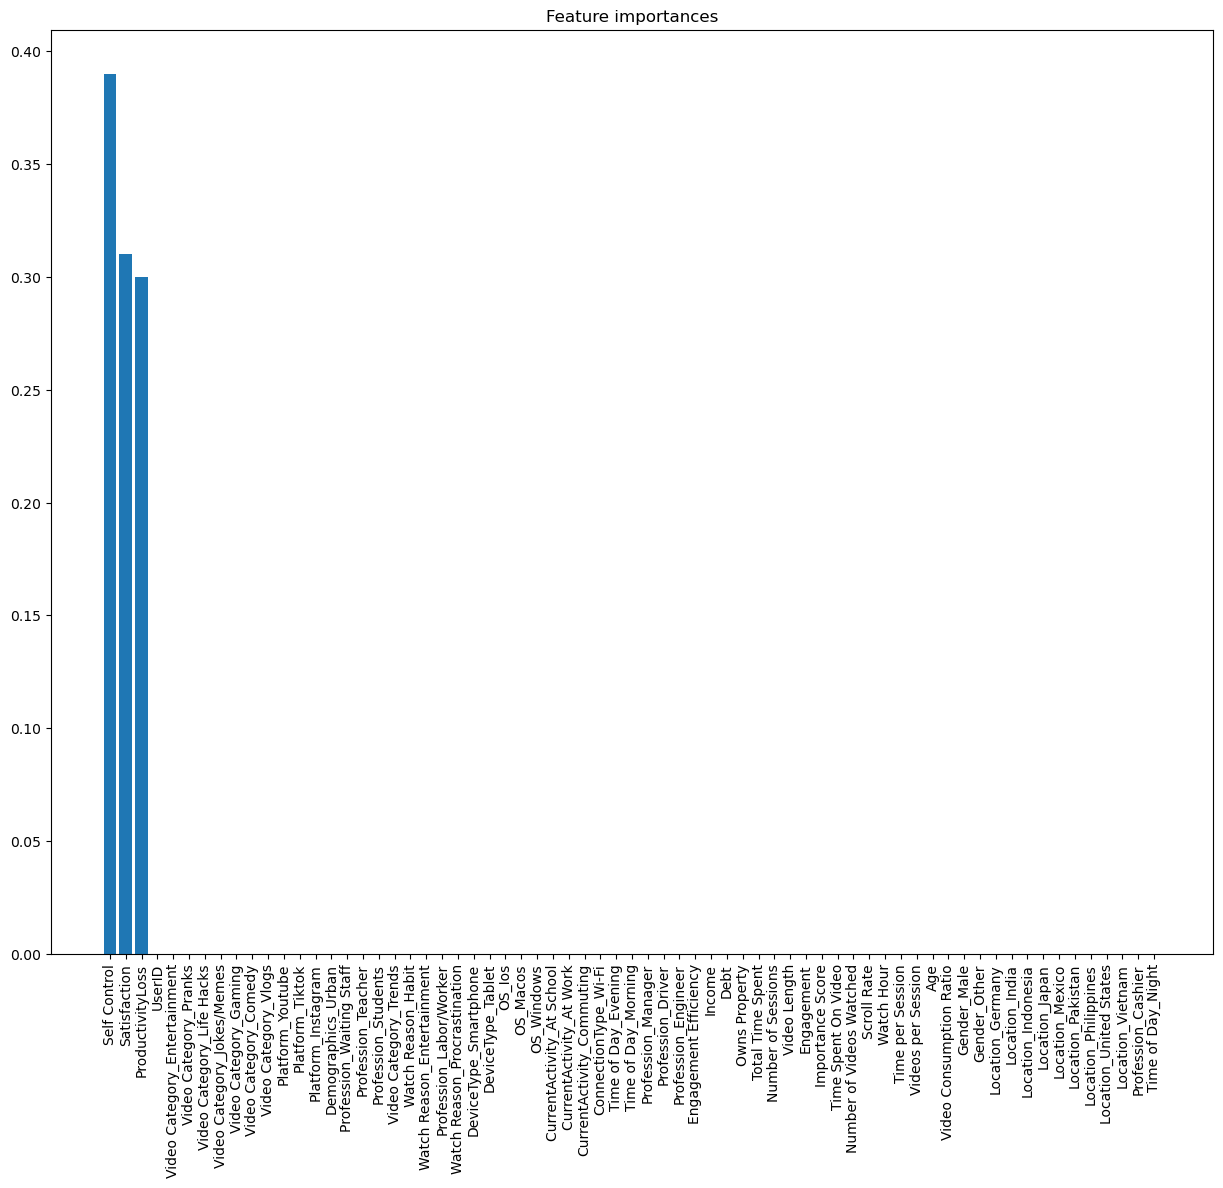

In [176]:
df = pd.read_csv("data_clean.csv")
df['Addiction Status'] = np.where(df['Addiction Level'] <= 4, 0, 1)
df.drop(['Watch Time', 'Addiction Level'], axis=1, inplace=True)
df = pd.get_dummies(df, drop_first=True, dtype = int)

X = df.drop(columns=["Addiction Status"])
y = df["Addiction Status"]

standardized_X = standardize_data(X)

X_train, X_test, y_train, y_test = train_test_split(standardized_X, y, test_size=0.2, random_state=100, shuffle=True)

model = RandomForestRegressor()
model.fit(X_train, y_train)

features = standardized_X.columns
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values(ascending=False, inplace=True)

plt.figure()
plt.figure(figsize=(15, 12))
plt.title("Feature importances")
plt.bar(importances.index, importances.values, align="center")
plt.xticks(rotation=90)
plt.show()